# Unit Reports

Create a report analyzing an individual unit.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
from scipy.stats import sem

from convnwb.io import load_nwbfile

from spiketools.measures.spikes import compute_isis
from spiketools.measures.trials import compute_segment_frs
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.trials import compare_pre_post_activity
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.spatial.occupancy import (compute_occupancy, compute_bin_edges, compute_bin_assignment,
                                          compute_bin_counts_pos, compute_bin_counts_assgn)
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.target import compute_target_bins
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.utils import convert_2dindices
from spiketools.utils.extract import get_values_by_times
from spiketools.utils.base import select_from_list
from spiketools.utils.run import create_methods_list
from spiketools.utils.epoch import epoch_spikes_by_event, epoch_spikes_by_range
from spiketools.plts.spikes import plot_isis
from spiketools.plts.spatial import plot_positions, plot_heatmap, create_heat_title
from spiketools.plts.trials import plot_rasters, create_raster_title
from spiketools.plts.data import plot_bar, plot_polar_hist, plot_text
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.plts.annotate import color_pvalue

In [3]:
import sys
sys.path.append('../code')
from utils import select_navigation, stack_trials
from models import (create_df_place, fit_anova_place,
                    create_df_target, fit_anova_target,
                    create_df_serial, fit_anova_serial)
from reports import create_unit_info, create_unit_str

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/tom/Data/JacobsLab/WVTH/nwb'
#data_folder = '/data12/jacobs_lab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv001',
    'session' : 2
}

In [7]:
# Set which example unit to extract
#uind = 84
uind = 0

In [8]:
# Define bins to use
bins = [9, 12]
chest_bins = [5, 7]

# Define minimum occupancy
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

# TEMP:
speed_thresh = 0

# Set the time range to analyze
trial_range = [-1, 1]
pre_window = [-1, 0]
post_window = [0, 1]

In [9]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 25

In [10]:
# Set which methods to run
METHODS = {
    'PLACE' : ['ANOVA', 'INFO'],
    'TARGET' : ['ANOVA', 'INFO'],
    'SERIAL' : ['ANOVA']
}

## Load Data

In [11]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

#### Trial Data

In [12]:
# Get start and stop time of trials
trial_starts = nwbfile.trials['start_time'].data[:]
trial_stops = nwbfile.trials['stop_time'].data[:]

In [13]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

In [14]:
# Get trial indices of interest
chest_trials = nwbfile.trials.chest_trials[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

In [15]:
# Get masks for full and empty chest trials
full_mask = nwbfile.trials.full_chest.data[:]
empty_mask = np.invert(full_mask)

In [16]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)

#### Position data

In [17]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:], 
              nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-15, 15])]

In [18]:
# Get position data, selecting from navigation periods, and recombine across trials
ptimes_trials, positions_trials = select_navigation(\
    nwbfile.acquisition['position']['player_position'], nav_starts, nav_stops)
ptimes, positions = stack_trials(ptimes_trials, positions_trials)

In [19]:
# Get speed data, selecting from navigation periods, and recombining across trials
stimes, speed = stack_trials(*select_navigation(\
    nwbfile.processing['position_measures']['speed'], nav_starts, nav_stops))

In [20]:
# Get the chest positions
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T

#### Get Spikes

In [21]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

### Precompute Some Things

In [22]:
# Get the spiking data for each trial
all_trials = epoch_spikes_by_range(spikes, trial_starts, trial_stops, reset=True)

In [23]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [24]:
# Epoch around chest openings
all_chests = epoch_spikes_by_event(spikes, np.concatenate(chest_openings), trial_range)
empty_trials = select_from_list(all_chests, empty_mask)
full_trials = select_from_list(all_chests, full_mask)

In [25]:
# Compute bin edges
x_bin_edges, y_bin_edges = compute_bin_edges(positions, bins, area_range=area_range)

In [26]:
# Get position values for each spike
spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=time_thresh)

In [27]:
# Compute occupancy
occ_kwargs = {'minimum' : min_occ, 'set_nan' : True}
occ = compute_occupancy(positions, ptimes, bins, area_range,
                        speed, speed_thresh, time_thresh, **occ_kwargs)

In [28]:
# Compute spatial bin assignments & binned firing, and normalize by occupancy
place_bins = compute_bin_counts_pos(spike_positions, bins, area_range, occ)

In [29]:
# Compute edges for chest binning
ch_x_edges, ch_y_edges = compute_bin_edges(positions, chest_bins, area_range)

# Assign each chest to a bin & compute equivalent 1d indices
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, ch_x_edges, ch_y_edges)
chbins = convert_2dindices(ch_xbin, ch_ybin, chest_bins)

# Compute chest occupancy
chest_occupancy = compute_bin_counts_assgn(chest_bins, ch_xbin, ch_ybin)

### Statistical Measures

In [30]:
# Initialize results store
results = {}

In [31]:
# Compare pre/post chest events, computing firing rates & t-test comparison
fr_pre_all, fr_post_all, results['fr_t_val_all'], results['fr_p_val_all'] = \
    compare_pre_post_activity(all_chests, pre_window, post_window)
fr_pre_empt, fr_post_empt, results['fr_t_val_empt'], results['fr_p_val_empt'] = \
    compare_pre_post_activity(empty_trials, pre_window, post_window)
fr_pre_full, fr_post_full, results['fr_t_val_full'], results['fr_p_val_full'] = \
    compare_pre_post_activity(full_trials, pre_window, post_window)

In [32]:
# Place cell analysis
if 'INFO' in METHODS['PLACE']:
    results['place_info'] = compute_spatial_information(place_bins, occ)
if 'ANOVA' in METHODS['PLACE']:
    place_trial = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops, 
                                           area_range, speed, speed_thresh, time_thresh,
                                           flatten=True, **occ_kwargs)
    results['place_anova'] = fit_anova_place(create_df_place(place_trial))

In [33]:
# Target cell analysis
target_frs = compute_segment_frs(spikes, seg_times)
target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)

if 'INFO' in METHODS['TARGET']:
    results['target_info'] = compute_spatial_information(target_bins, chest_occupancy)
if 'ANOVA' in METHODS['TARGET']:
    target_df = create_df_target({'trial' : chest_trials, 'target_bin' : chbins,
                                  'fr' : target_frs.flatten()})
    results['target_anova'] = fit_anova_target(target_df)

In [34]:
# Serial position analysis
sp_all_frs = compute_segment_frs(spikes, seg_times)
results['serial_anova'] = fit_anova_serial(create_df_serial(sp_all_frs))

### Surrogates

In [35]:
# Collect list of which analyses are being run for surrogates, and initialize surrogate stores
surr_analyses = create_methods_list(METHODS)
surrs = {analysis : np.zeros(n_surrogates) for analysis in surr_analyses}

In [36]:
# Compute surrogate measures
for ind, shuffle in enumerate(times_shuffle):    
    
    # PLACE
    if 'INFO' in METHODS['PLACE']:
        surr_place_bins = compute_place_bins(shuffle, positions, ptimes, bins, 
                                             area_range, speed, speed_thresh, time_thresh)
        surrs['place_info'][ind] = compute_spatial_information(surr_place_bins, occ, normalize=True)
    if 'ANOVA' in METHODS['PLACE']:
        surr_place_trial = compute_trial_place_bins(shuffle, positions, ptimes, bins,
                                                    nav_starts, nav_stops, area_range,
                                                    speed, speed_thresh, time_thresh,
                                                    flatten=True, **occ_kwargs)
        surrs['place_anova'][ind] = fit_anova_place(create_df_place(surr_place_trial))
    
    # TARGET
    if 'INFO' in METHODS['TARGET']:
        surr_target_frs = compute_segment_frs(shuffle, seg_times)
        surr_target_bins = compute_target_bins(surr_target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
        surrs['target_info'][ind] = compute_spatial_information(surr_target_bins, chest_occupancy)

    if 'ANOVA' in METHODS['TARGET']:
        surr_target_df = create_df_target({'trial' : chest_trials, 'target_bin' : chbins,
                                           'fr' : compute_segment_frs(shuffle, seg_times).flatten()})
        surrs['target_anova'][ind] = fit_anova_target(surr_target_df)
    
    # SERIAL POSITION
    if 'ANOVA' in METHODS['SERIAL']:
        surr_sp_all_frs = compute_segment_frs(shuffle, seg_times)
        surrs['serial_anova'][ind] = fit_anova_serial(create_df_serial(surr_sp_all_frs))

In [37]:
# Compute surrogate statistics
for analysis in surr_analyses:
    results[analysis + '_surr_p_val'], results[analysis + '_surr_z_score'] = \
        compute_surrogate_stats(results[analysis], surrs[analysis])

## Create Report

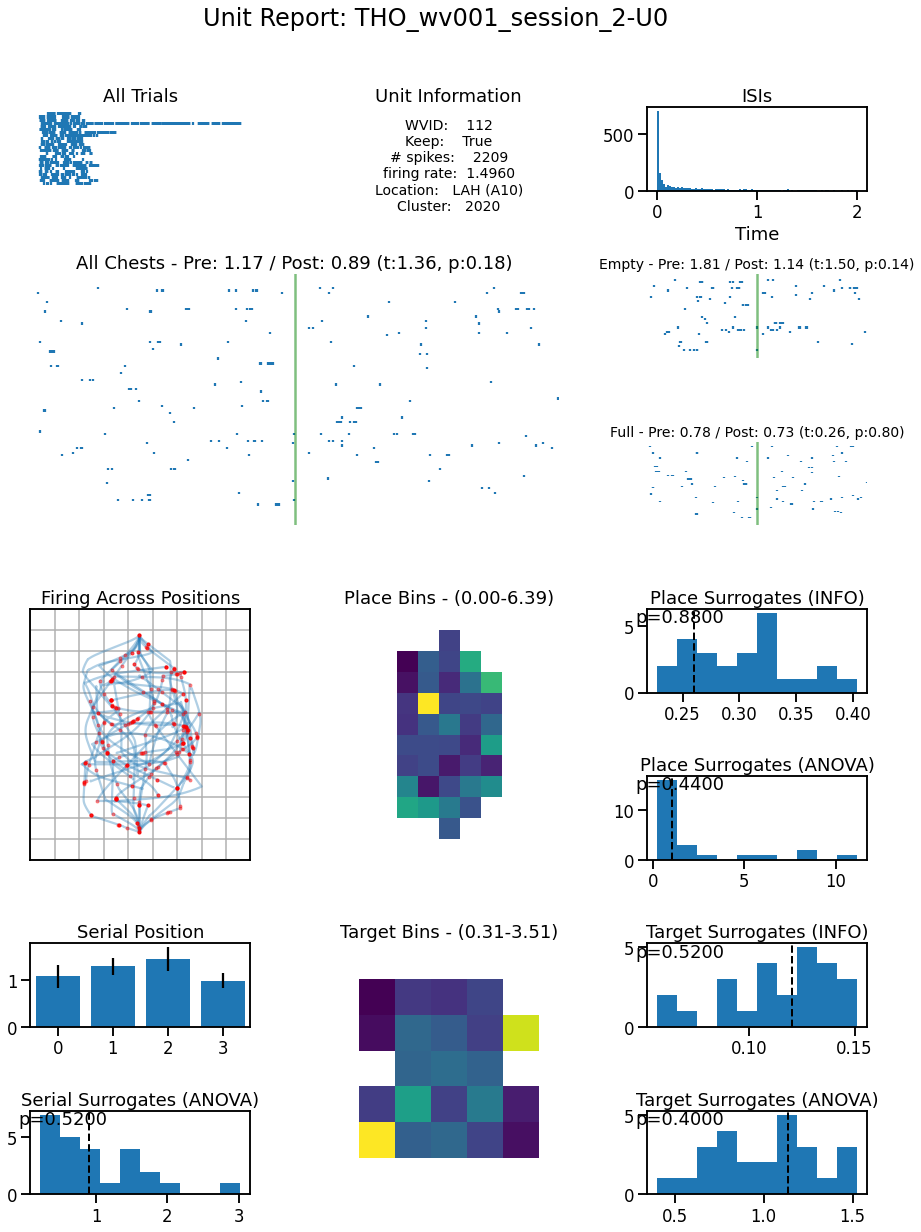

In [38]:
# Initialize figure with grid layout
grid = make_grid(7, 3, figsize=(15, 20), wspace=0.4, hspace=1.,
                 title='Unit Report: {}-U{}'.format(nwbfile.session_id, uind))

# 00: plot rasters across all trials
plot_rasters(all_trials, title='All Trials', ax=get_grid_subplot(grid, 0, 0))

# 01: unit information
plot_text(create_unit_str(create_unit_info(nwbfile.units[uind])),
          title='Unit Information', ax=get_grid_subplot(grid, 0, 1))

# 02: inter-spike intervals
plot_isis(compute_isis(spikes), bins=100, range=(0, 2), ax=get_grid_subplot(grid, 0, 2))

# 10: chest related firing
plot_rasters(all_chests, xlim=trial_range, vline=0, 
             title=create_raster_title('All Chests', fr_pre_all, fr_post_all, 
                 results['fr_t_val_all'], results['fr_p_val_all']),
             title_color=color_pvalue(results['fr_p_val_all']),
             ax=get_grid_subplot(grid, slice(1, 3), slice(0, 2)))

# 12&22: Compare Empty & Full chest trials
plot_rasters(empty_trials, xlim=trial_range, vline=0,
             title=create_raster_title('Empty', fr_pre_empt, fr_post_empt,
                 results['fr_t_val_empt'], results['fr_p_val_empt']),
             title_color=color_pvalue(results['fr_p_val_empt']), title_fontsize=14,
             ax=get_grid_subplot(grid, 1, 2))
plot_rasters(full_trials, xlim=trial_range, vline=0, 
             title=create_raster_title('Full', fr_pre_full, fr_post_full,
                 results['fr_t_val_full'], results['fr_p_val_full']),
             title_color=color_pvalue(results['fr_p_val_full']), title_fontsize=14,
             ax=get_grid_subplot(grid, 2, 2))

# ax30: positional firing
plot_positions(positions_trials, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               title='Firing Across Positions', 
               ax=get_grid_subplot(grid, slice(3, 5), 0))

# ax31: positional heatmap
plot_heatmap(place_bins, ax=get_grid_subplot(grid, slice(3, 5), 1), 
             title=create_heat_title('Place Bins', place_bins))

# ax32: place surrogates (info)
if 'INFO' in METHODS['PLACE']:
    plot_surrogates(surrs['place_info'], results['place_info'], results['place_info_surr_p_val'],
                    title='Place Surrogates (INFO)',
                    title_color=color_pvalue(results['place_info_surr_p_val']),
                    ax=get_grid_subplot(grid, 3, 2))

# ax42: place surrogates (anova)
if 'ANOVA' in METHODS['PLACE']:
    plot_surrogates(surrs['place_anova'], results['place_anova'], results['place_anova_surr_p_val'],
                    title='Place Surrogates (ANOVA)',
                    title_color=color_pvalue(results['place_anova_surr_p_val']),
                    ax=get_grid_subplot(grid, 4, 2))

# ax50: serial position
plot_bar(sp_all_frs.mean(0), [0, 1, 2, 3], yerr=sem(sp_all_frs, 0),
         title='Serial Position', ax=get_grid_subplot(grid, 5, 0))

# ax60: serial position surrogates
plot_surrogates(surrs['serial_anova'], results['serial_anova'],
                results['serial_anova_surr_p_val'],
                title='Serial Surrogates (ANOVA)',
                title_color=color_pvalue(results['serial_anova_surr_p_val']),
                ax=get_grid_subplot(grid, 6, 0))

# ax51: spatial target firing
plot_heatmap(target_bins, ax=get_grid_subplot(grid, slice(5, 7), 1),
             title=create_heat_title('Target Bins', target_bins))

# ax52: target surrogates (info)
if 'INFO' in METHODS['TARGET']:
    plot_surrogates(surrs['target_info'], results['target_info'],
                    results['target_info_surr_p_val'],
                    title='Target Surrogates (INFO)',
                    title_color=color_pvalue(results['target_info_surr_p_val']),
                    ax=get_grid_subplot(grid, 5, 2))

# ax62: target surrogates (anova)
if 'ANOVA' in METHODS['TARGET']:
    plot_surrogates(surrs['target_anova'], results['target_anova'],
                    results['target_anova_surr_p_val'],
                    title='Target Surrogates (ANOVA)',
                    title_color=color_pvalue(results['target_anova_surr_p_val']),
                    ax=get_grid_subplot(grid, 6, 2))